In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import cv2

from io import BytesIO
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm


# after finding dups, loading the data

In [2]:
isic_dup_df = pd.read_csv('../data/dup_imgs.txt', header=None)
print(isic_dup_df)

                                                      0   1
0     [{'_id': '81761be16c5d538791a159d92cbe734cd40b... NaN
1             'items': [{'capture_time': 'Time unknown' NaN
2                  'file_name': '/Users/peeti_mac/Py... NaN
3                                  'file_size': 4400998 NaN
4                          'image_size': '6000 x 4000'} NaN
...                                                 ...  ..
5066                    {'capture_time': 'Time unknown' NaN
5067               'file_name': '/Users/peeti_mac/Py... NaN
5068                                'file_size': 254118 NaN
5069                      'image_size': '1024 x 1024'}] NaN
5070                                       'total': 2}] NaN

[5071 rows x 2 columns]


# read the dup file and create a dataframe

In [3]:
df_sp = isic_dup_df[0].str.split(expand=True)
df_sp.columns = ['head','value','del1','del2']
df_sp = df_sp[['head','value']]
df_sp

,head,value
0,[{'_id':,'81761be16c5d538791a159d92cbe734cd40b0d73791c3...
1,'items':,[{'capture_time':
2,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
3,'file_size':,4400998
4,'image_size':,'6000
...,...,...
5066,{'capture_time':,'Time
5067,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
5068,'file_size':,254118
5069,'image_size':,'1024


# cleanup and remove unnecessary rows
# keep only file name, total dups, and file size/]

In [4]:
df_clean0= df_sp.loc[np.where((df_sp['head'] == "'file_name':") | (df_sp['head'] == "'total':")| (df_sp['head'] == "'file_size':"))].reset_index()
df_clean0

,index,head,value
0,2,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1,3,'file_size':,4400998
2,6,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
3,7,'file_size':,4400998
4,9,'total':,2}
...,...,...,...
2529,5063,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
2530,5064,'file_size':,254118
2531,5067,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
2532,5068,'file_size':,254118


# check if there is any irralavant file name such as measles

In [5]:
df_clean0[df_clean0['value'].str.contains('measles')].index

Int64Index([1245, 1247, 1849, 1851], dtype='int64')

In [6]:
display(df_clean0.iloc[1245:1250,:])
display(df_clean0.iloc[1849:1854,:])

print('\nLook at the first records, it is not part of ISIC')
display(df_clean0.iloc[1245:1250,:]['value'][1245])

,index,head,value
1245,2492,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1246,2493,'file_size':,14638
1247,2496,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1248,2498,'file_size':,14638
1249,2500,'total':,2}


,index,head,value
1849,3701,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1850,3703,'file_size':,29169
1851,3706,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1852,3708,'file_size':,29260
1853,3710,'total':,2}



Look at the first records, it is not part of ISIC


"'/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/images/Measles/measles(49).jpg'"

In [7]:
df_clean_no_measle = df_clean0[~df_clean0.index.isin([1849,1850,1851,1852,1853,1245,1246,1247,1248,1249])].iloc[:,1:].reset_index()
df_clean_no_measle = df_clean_no_measle.iloc[:,1:]
df_clean_no_measle

,head,value
0,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1,'file_size':,4400998
2,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
3,'file_size':,4400998
4,'total':,2}
...,...,...
2519,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
2520,'file_size':,254118
2521,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
2522,'file_size':,254118


In [8]:
df_clean_no_measle[df_clean_no_measle['head'] == "'total':"].drop_duplicates()

,head,value
4,'total':,2}
1553,'total':,4}
2523,'total':,2}]


# review those 4 duplicates

,head,value
1545,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1546,'file_size':,261084
1547,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1548,'file_size':,281860
1549,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1550,'file_size':,2271764
1551,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1552,'file_size':,48770
1553,'total':,4}





Review those 4 images


Text(0.5, 1.0, 'ISIC_0032405.jpg')

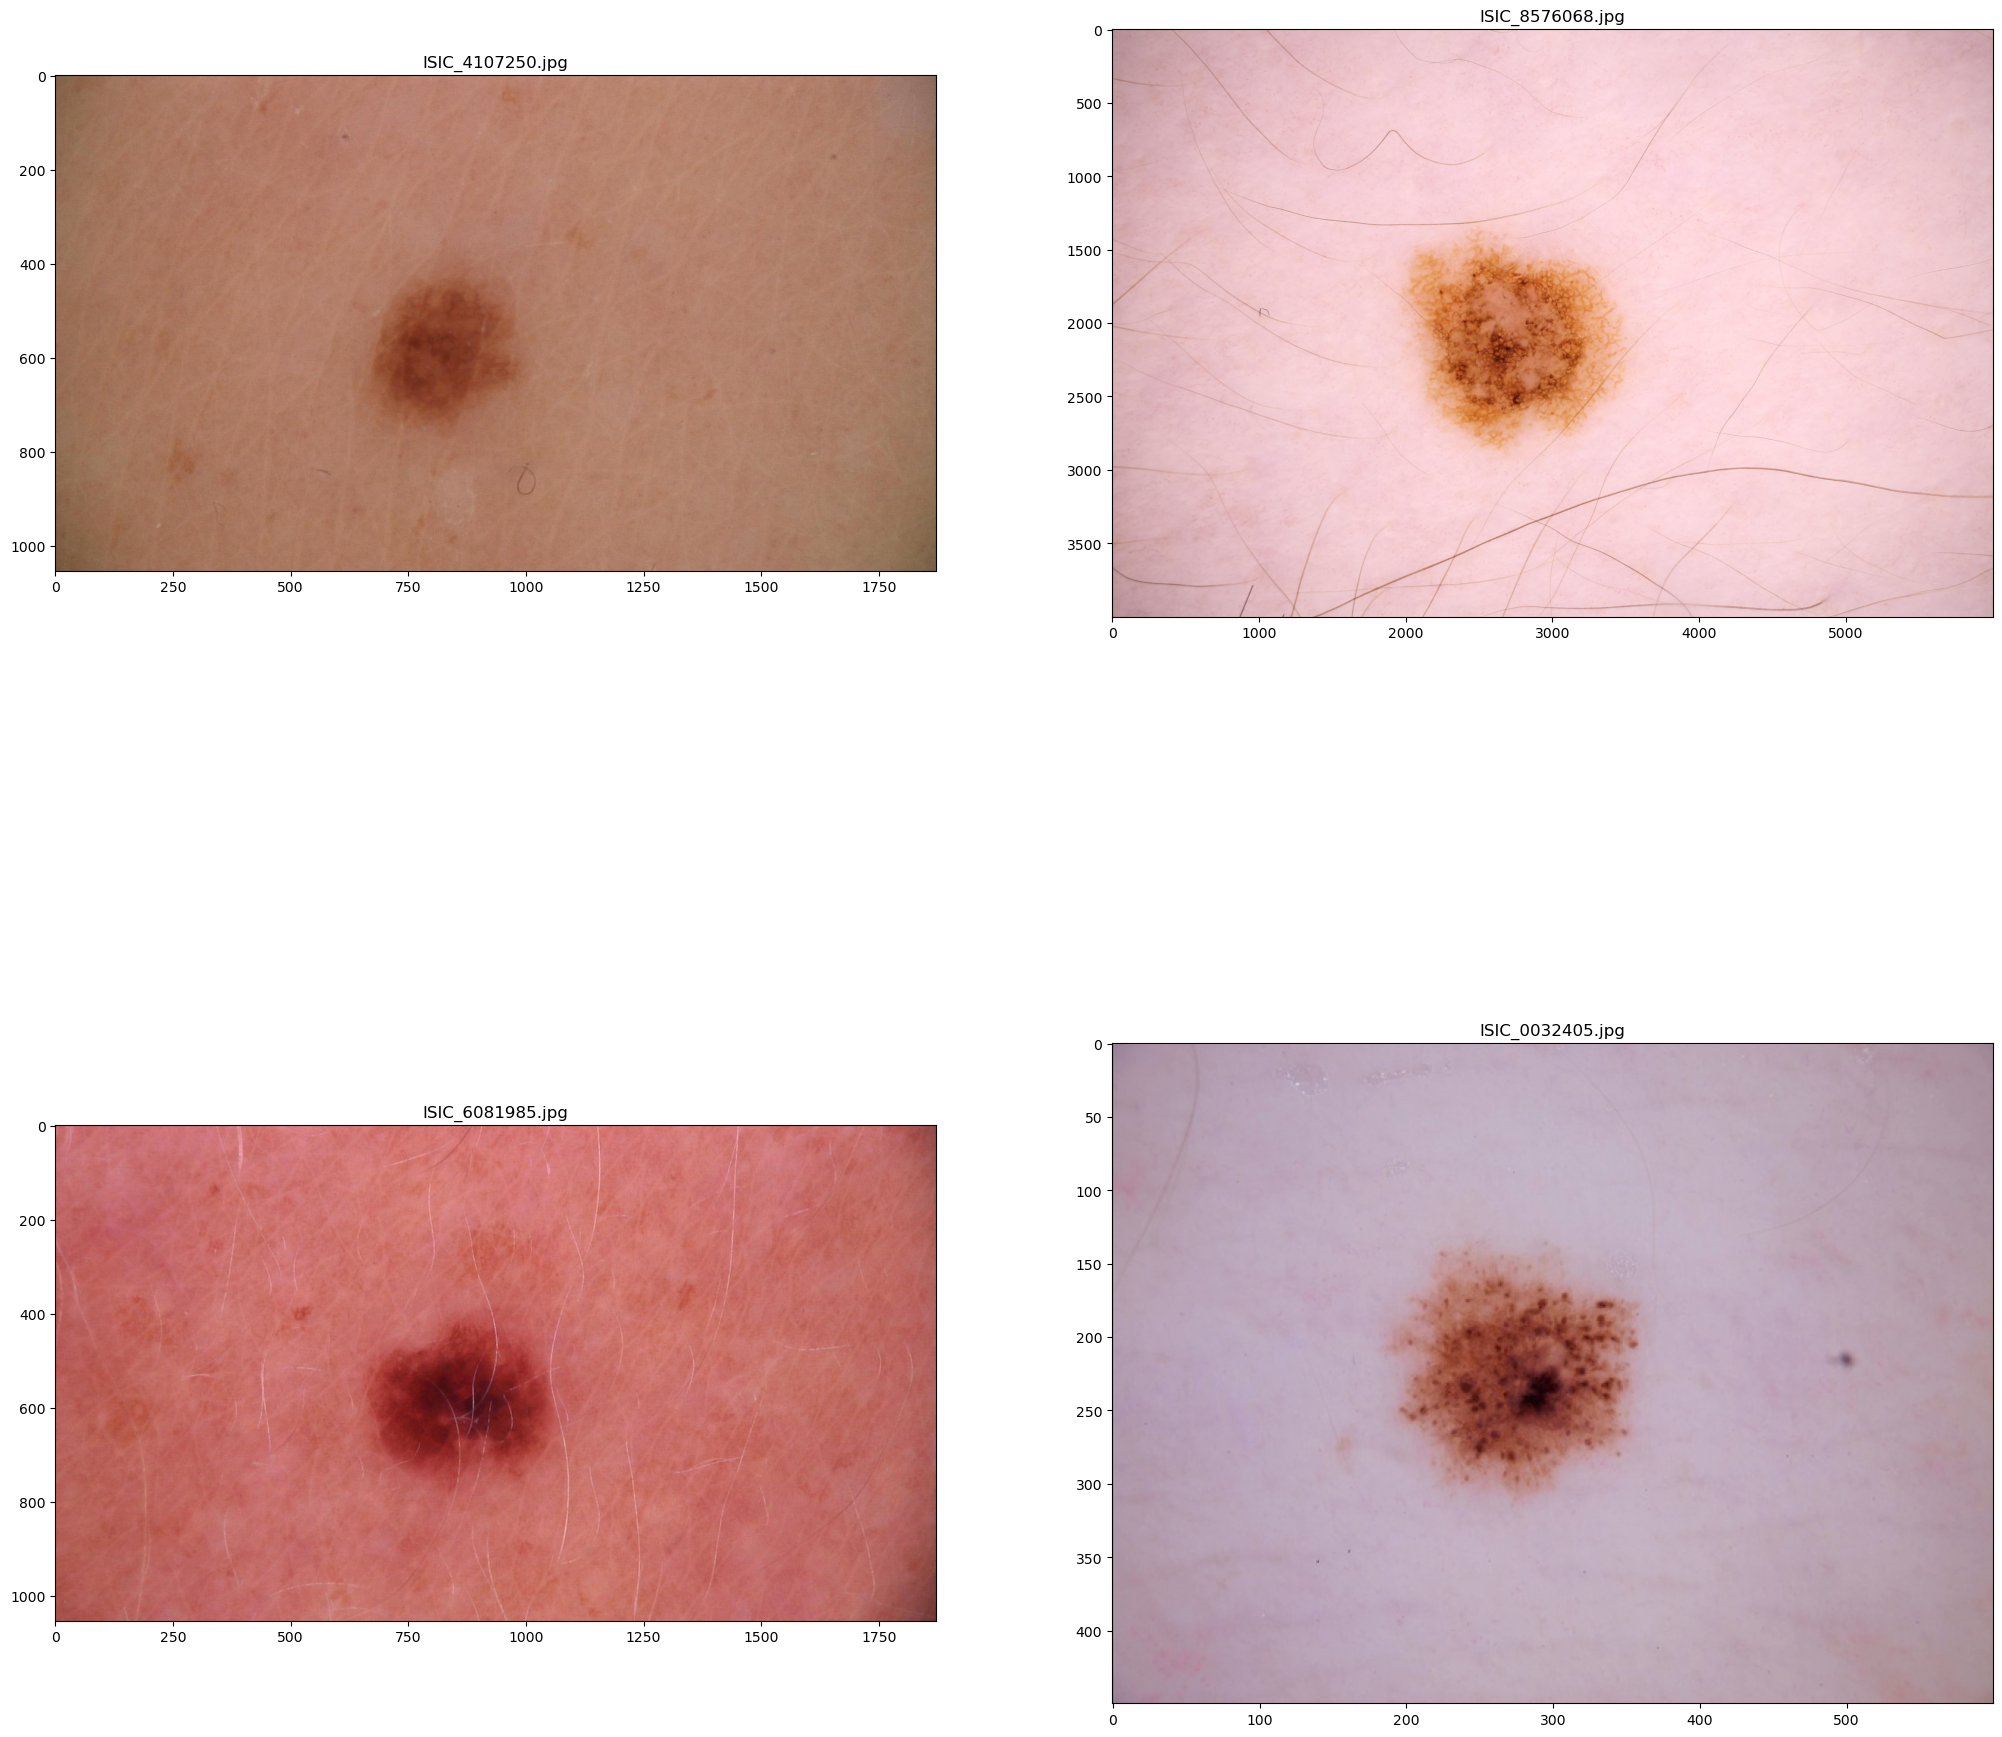

In [9]:
display(df_clean_no_measle.iloc[1545:1554,:])
print('\n')
df_clean_no_measle.loc[[1544,1546,1548,1550]][['value']]\
        .apply(lambda x: x.str.replace('/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/',''))

print('\nReview those 4 images')

fig, ax = plt.subplots(2,2,figsize=(25, 25))
img1 = '/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/ISIC_4107250.jpg'
img2 = '/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/ISIC_6081985.jpg'
img3 = '/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/ISIC_8576068.jpg'
img4 = '/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/ISIC_0032405.jpg'
pil_img1 = Image.open((img1))
pil_img2 = Image.open((img2))
pil_img3 = Image.open((img3))
pil_img4 = Image.open((img4))

img1_nm = img1.split('/')[-1]
img2_nm = img2.split('/')[-1]
img3_nm = img3.split('/')[-1]
img4_nm = img4.split('/')[-1]


ax[0,0].imshow(pil_img1)
ax[0,0].set_title(img1_nm)
ax[1,0].imshow(pil_img2)
ax[1,0].set_title(img2_nm)

ax[0,1].imshow(pil_img3)
ax[0,1].set_title(img3_nm)
ax[1,1].imshow(pil_img4)
ax[1,1].set_title(img4_nm)


# after reviewing, I dont think these 4 images are duplicated
## remove these 4 images

In [10]:
df_clean_no_4 = df_clean_no_measle[~df_clean_no_measle.index.isin([1545,1546,1547,1548,1549,1550,1551,1552,1553])].reset_index()
df_clean_no_4 = df_clean_no_4.iloc[:,1:]
df_clean_no_4.head(30)

,head,value
0,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
1,'file_size':,4400998
2,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
3,'file_size':,4400998
4,'total':,2}
5,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
6,'file_size':,3627576
7,'file_name':,'/Users/peeti_mac/PycharmProjects/skin-image-c...
8,'file_size':,3627576
9,'total':,2}


In [11]:
df_clean_no_4[df_clean_no_4['head'] == "'total':"].drop_duplicates()

,head,value
4,'total':,2}
2514,'total':,2}]


# create a dataframe that has duplicating images side by side

In [13]:
# first image
image1 = []
for i in range(0,df_clean_no_4.shape[0], 5):
    img = df_clean_no_4[df_clean_no_4.index == i][['value']].values
    image1.append(img)
# print(image1)
to_remove_dup_df1 = pd.DataFrame([np.array(x)[0].split('/')[-1].replace("'","") for row in image1 for x in row])
to_remove_dup_df1.columns = ['image1']
print('first image column created')
print(to_remove_dup_df1.head())
print('\n')

# first image size 
image1_size = []
for i in range(1,df_clean_no_4.shape[0], 5):
    img = df_clean_no_4[df_clean_no_4.index == i][['value']].values
    image1_size.append(img)
# print(image1_size)

to_remove_dup_df2 = pd.DataFrame([np.array(x)[0].split('/')[-1].replace("'","") for row in image1_size for x in row])
to_remove_dup_df2.columns = ['image1_size']
print('image size column for the first image created')
print(to_remove_dup_df2.head())
print('\n')

# second image
image2 = []
for i in range(2,df_clean_no_4.shape[0], 5):
    img = df_clean_no_4[df_clean_no_4.index == i][['value']].values
    image2.append(img)
# print(image1)
to_remove_dup_df3 = pd.DataFrame([np.array(x)[0].split('/')[-1].replace("'","") for row in image2 for x in row])
to_remove_dup_df3.columns = ['image2']
print('second image column created')
print(to_remove_dup_df3.head())
print('\n')

# second image size 
image2_size = []
for i in range(3,df_clean_no_4.shape[0], 5):
    img = df_clean_no_4[df_clean_no_4.index == i][['value']].values
    image2_size.append(img)
# print(image1_size)

to_remove_dup_df4 = pd.DataFrame([np.array(x)[0].split('/')[-1].replace("'","") for row in image2_size for x in row])
to_remove_dup_df4.columns = ['image2_size']
print('image size column for the first image created')
print(to_remove_dup_df4.head())
print('\n')

first image column created
             image1
0  ISIC_0535654.jpg
1  ISIC_0386664.jpg
2  ISIC_2749059.jpg
3  ISIC_1122727.jpg
4  ISIC_6140773.jpg


image size column for the first image created
  image1_size
0     4400998
1     3627576
2     4261439
3     2110206
4     2568824


second image column created
             image2
0  ISIC_1368313.jpg
1  ISIC_1922645.jpg
2  ISIC_1312208.jpg
3  ISIC_6968835.jpg
4  ISIC_1323471.jpg


image size column for the first image created
  image2_size
0     4400998
1     3627576
2     4261439
3     2110206
4     2568824




# now combine the created dataframes

In [60]:
dup_df = to_remove_dup_df1.merge(to_remove_dup_df3, how='outer', left_index=True, right_index=True)\
            .merge(to_remove_dup_df2, how='outer', left_index=True, right_index=True)\
            .merge(to_remove_dup_df4, how='outer', left_index=True, right_index=True)
print(dup_df.shape[0])
print('\n')
dup_df['image1_size']  = dup_df['image1_size'].astype('int')
dup_df['image2_size']  = dup_df['image2_size'].astype('int')
dup_df['match'] = dup_df['image1_size']-dup_df['image2_size']
dup_df_review = dup_df.query('match != 0').reset_index()
dup_df_review = dup_df_review.iloc[:,1:]
print(dup_df_review.shape)
dup_df_review.head()

503


(22, 5)


,image1,image2,image1_size,image2_size,match
0,ISIC_0014289_downsampled.jpg,ISIC_7101732.jpg,142480,1025354,-882874
1,ISIC_2887033.jpg,ISIC_5194874.jpg,1741669,1739045,2624
2,ISIC_0055541.jpg,ISIC_0072938.jpg,122750,121337,1413
3,ISIC_0056850.jpg,ISIC_0067024.jpg,226954,229009,-2055
4,ISIC_0016053_downsampled.jpg,ISIC_6847618.jpg,130505,1152298,-1021793


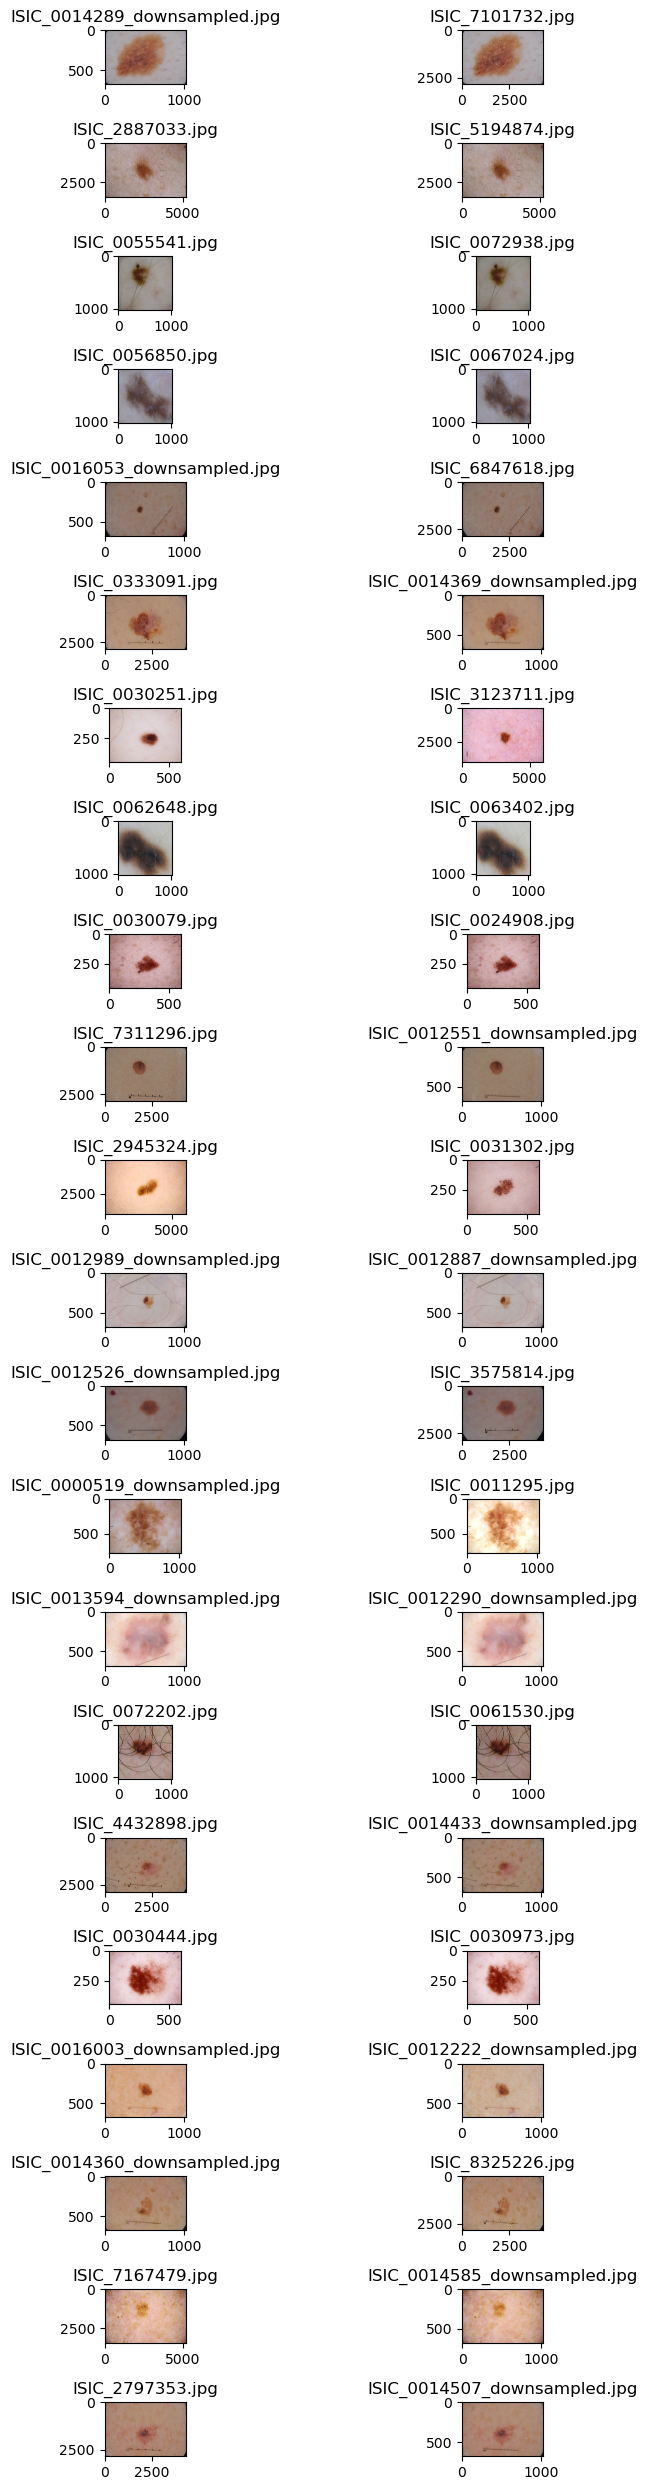

In [59]:
img_path = '/Users/peeti_mac/PycharmProjects/skin-image-classification/data/image/isic_images/'
fig, ax = plt.subplots(22,2,figsize=(8, 25),tight_layout=True)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for row in range(22):
    
    img = img_path+dup_df_review['image1'][row]
    img_nm = img.split('/')[-1]
    # print(img_nm)
    pil_img1 = Image.open((img))
    ax[row,0].imshow(pil_img1)
    ax[row,0].set_title(img_nm)
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    img2 = img_path+dup_df_review['image2'][row]
    img2_nm = img2.split('/')[-1]
    # print(img_nm)
    pil_img2 = Image.open((img2))
    ax[row,1].imshow(pil_img2)
    ax[row,1].set_title(img2_nm)
    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

plt.show()
# print(row,col)